In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
import json

In [2]:
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_1T = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 180}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96 // 8}
vit_era5 = {'l': 64800, 'e': 5120, 'h': 256, 'depth': 24}
### model
model = gpt3_1T
b = 1
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

model: batch size = 1, seq length = 2048, embed = 25600, attention heads = 160, depth = 180


In [3]:
with open('config.json', 'r') as file:
    system = json.load(file)

In [4]:
def print_df(df_mlp, df_sa):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    display(df_mlp[cols])
    display(df_mlp[layer_track_cols].sum() * depth)
    display(df_sa[cols])
    display(df_sa[layer_track_cols].sum() * depth)
    t_itr = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() + df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
    print('time for 1 itr = {}'.format(t_itr))

    f1 = 3 # 1 fp16 wt, 1 fp32 copy
    f2 = 5 # 1 fp16 grad, 2 fp32 means and variances
    mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
           df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
    print('mem consumed = {}'.format(mem))

In [5]:
m1 = 4
system['nvlink_size'] = 4
b = 1
t1 = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
df_mlp = mlp_1d(b, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
df_sa = sa_1d(b, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,1.310720,1.310720,2.684302,0.104858,0.000000,reducescatter,5.368001,0.104858,reducescatter,0.008604,0.000000,8.799121,0.017293,0.000087,8.798133,0.025896
1,fc1-bias,0.000051,0.000051,0.000052,0.000000,0.000000,none,0.000052,0.000000,allreduce,0.000067,0.000000,0.009963,0.000067,0.000000,0.009963,0.000135
2,act1,0.000000,0.000000,0.000052,0.104858,0.000000,none,0.000052,0.000000,none,0.000135,0.000000,0.004984,0.000202,0.000000,0.003323,0.000337
3,dpr1,0.000000,0.000000,0.000052,0.052429,0.000000,none,0.000052,0.000000,none,0.000169,0.000000,0.003987,0.000169,0.000000,0.003987,0.000337
4,fc2,1.310720,1.310720,2.684302,0.104858,0.104858,reducescatter,5.368001,0.000000,reducescatter,0.008691,0.000087,8.799121,0.017205,0.000000,8.798133,0.025896
5,fc2-bias,0.000051,0.000051,0.000052,0.000000,0.000000,none,0.000052,0.000000,allreduce,0.000067,0.000000,0.009963,0.000067,0.000000,0.009963,0.000135
6,dpr2,0.000000,0.000000,0.000013,0.013107,0.000000,none,0.000013,0.000000,none,0.000042,0.000000,0.003987,0.000042,0.000000,0.003987,0.000084
7,ln1,0.000102,0.000102,0.000118,0.026214,0.104858,allgather,0.000157,0.104858,reducescatter,0.000121,0.000087,0.044767,0.000172,0.000087,0.023904,0.000293


activation_buffer      73.138176
weights_mem           471.896064
weights_grad_mem      471.896064
flops_fwd             966.410109
flops_bwd            1932.548898
t_fwd                   3.221304
t_fwd_comm              0.031457
t_bwd                   6.339121
t_bwd_comm              0.031457
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.983040,0.983040,2.013227,0.104858,0.000000,reducescatter,4.025988,0.104858,reducescatter,0.006453,0.000000,8.601388,0.012991,0.000087,8.600394,0.019444
1,fusedla,0.000000,0.000000,0.109877,0.105185,0.000000,none,0.274100,0.000000,none,0.000352,0.000000,5.214419,0.000879,0.000000,6.503939,0.001231
2,vproj,0.327680,0.327680,0.671036,0.026214,0.104858,reducescatter,1.342000,0.000000,reducescatter,0.002238,0.000087,7.290273,0.004301,0.000000,7.289881,0.006539
3,vproj-bias,0.000051,0.000051,0.000052,0.000000,0.000000,none,0.000052,0.000000,allreduce,0.000067,0.000000,0.009963,0.000067,0.000000,0.009963,0.000135
4,dpr_v,0.000000,0.000000,0.000013,0.013107,0.000000,none,0.000013,0.000000,none,0.000042,0.000000,0.003987,0.000042,0.000000,0.003987,0.000084
5,ln2,0.000102,0.000102,0.000118,0.026214,0.104858,allgather,0.000157,0.104858,reducescatter,0.000121,0.000087,0.044767,0.000172,0.000087,0.023904,0.000293


activation_buffer      49.604198
weights_mem           235.957248
weights_grad_mem      235.957248
flops_fwd             502.978255
flops_bwd            1015.615940
t_fwd                   1.669272
t_fwd_comm              0.031457
t_bwd                   3.321422
t_bwd_comm              0.031457
dtype: float64

time for 1 itr = 14.551119477394016
mem consumed = 5785.5688704


In [6]:
m1 = 2
m2 = 2
t2 = 2
t1 = 2
df_mlp = mlp_2d(b, l, e, f, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, system=system)
df_sa = sa_2d_seqp(b, l, e, h, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, flash_attention=True, system=system)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,1.310720,1.310720,2.684355,0.026214,"[0.052428800000000005, 2.62144]","[broadcast, broadcast]",5.367372,"[2.62144, 0.052428800000000005, 0.052428800000...","[broadcast, reduce, broadcast, reduce]",0.010832,2.228224e-03,4.639627,0.021660,4.456448e-03,4.638472,0.032491
1,fc1-bias,0.000102,0.000102,0.000052,0.000000,0,none,0.000052,0.000102,allreduce,0.000067,0.000000e+00,0.009958,0.000068,3.413333e-07,0.009958,0.000135
2,act1,0.000000,0.000000,0.000052,0.104858,0,none,0.000052,0,none,0.000135,0.000000e+00,0.004984,0.000202,0.000000e+00,0.003323,0.000337
3,dpr1,0.000000,0.000000,0.000052,0.052429,0,none,0.000052,0,none,0.000169,0.000000e+00,0.003987,0.000169,0.000000e+00,0.003987,0.000337
4,fc2,1.310720,1.310720,2.684355,0.104858,"[0.20971520000000002, 2.62144]","[broadcast, broadcast]",5.367294,"[2.62144, 0.20971520000000002, 0.2097152000000...","[broadcast, reduce, broadcast, reduce]",0.010963,2.359296e-03,4.639627,0.021921,4.718592e-03,4.638404,0.032884
5,fc2-bias,0.000026,0.000026,0.000013,0.000000,0,none,0.000013,0.000026,allreduce,0.000017,0.000000e+00,0.009958,0.000017,8.533333e-08,0.009958,0.000034
6,dpr2,0.000000,0.000000,0.000013,0.013107,0,none,0.000013,0,none,0.000042,0.000000e+00,0.003987,0.000042,0.000000e+00,0.003987,0.000084
7,ln1,0.000004,0.000004,0.000009,0.002097,0.000004,allreduce,0.000013,0.000055,allreduce,0.000003,1.365333e-08,0.044768,0.000007,1.843200e-07,0.023906,0.000010


activation_buffer      54.641295
weights_mem           471.882977
weights_grad_mem      471.882977
flops_fwd             966.402370
flops_bwd            1932.275125
t_fwd                   4.000968
t_fwd_comm              0.825756
t_bwd                   7.935439
t_bwd_comm              1.651617
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.983040,0.983040,2.013266,0.026214,"[0.052428800000000005, 1.96608]","[broadcast, broadcast]",4.025523,"[1.96608, 0.052428800000000005, 0.052428800000...","[broadcast, reduce, broadcast, reduce]",0.008135,1.682091e-03,4.611677,0.016266,3.364181e-03,4.610522,0.024401
1,fusedla,0.000000,0.000000,0.109877,0.105185,0.104858,allgather,0.274074,"[0.10485760000000001, 0.10485760000000001]","[allgather, reducescatter]",0.000527,1.747627e-04,3.478088,0.001228,3.495253e-04,5.204277,0.001755
2,vproj,0.327680,0.327680,0.671089,0.026214,"[0.052428800000000005, 0.65536]","[broadcast, broadcast]",1.341823,"[0.65536, 0.052428800000000005, 0.052428800000...","[broadcast, reduce, broadcast, reduce]",0.002741,5.898240e-04,4.399646,0.005480,1.179648e-03,4.398486,0.008221
3,vproj-bias,0.000026,0.000026,0.000013,0.000000,0,none,0.000013,0.000026,allreduce,0.000017,0.000000e+00,0.009958,0.000017,8.533333e-08,0.009958,0.000034
4,dpr_v,0.000000,0.000000,0.000013,0.013107,0,none,0.000013,0,none,0.000042,0.000000e+00,0.003987,0.000042,0.000000e+00,0.003987,0.000084
5,ln2,0.000004,0.000004,0.000009,0.002097,0.000004,allreduce,0.000013,0.000055,allreduce,0.000003,1.365333e-08,0.044768,0.000007,1.843200e-07,0.023906,0.000010


activation_buffer      31.107318
weights_mem           235.934945
weights_grad_mem      235.934945
flops_fwd             502.968157
flops_bwd            1015.462491
t_fwd                   2.063571
t_fwd_comm              0.440404
t_bwd                   4.147355
t_bwd_comm              0.880852
dtype: float64

time for 1 itr = 18.147334298195204
mem consumed = 5748.291993600002


In [7]:
def plot(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        m1 = n
        t1 = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
        
        df_mlp = mlp_1d(b, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
        df_sa = sa_1d(b, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum()) * depth
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

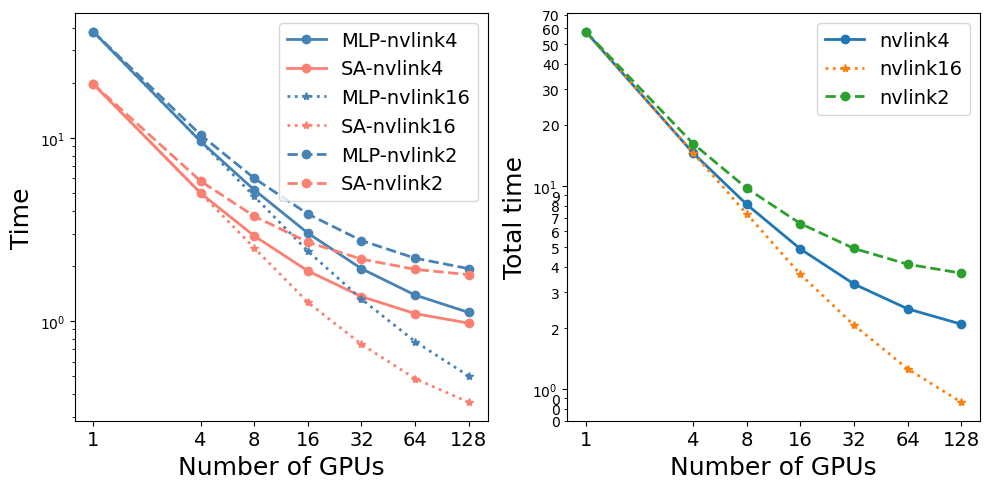

In [8]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 8, 16, 32, 64, 128]
with open('config.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
nvs = 2
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")

In [9]:
def set_gpus(n, nvs):
    parallelism = {}
    topology = {}
    factors_of_n = [[i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0]
    best_factor = factors_of_n[-1]
    parallelism['m1'] = best_factor[0]
    parallelism['m2'] = best_factor[1]
    
    m1 = parallelism['m1'] 
    m2 = parallelism['m2'] 
    topology['t1'] = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
    topology['t2'] = 1
        
    # print(parallelism, topology)
    return parallelism, topology

def plot_2d(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        parallelism, topology = set_gpus(n, system['nvlink_size'])
        
        df_mlp = mlp_2d(b, l, e, f, parallelism=parallelism, topology=topology, system=system)
        df_sa = sa_2d_seqp(b, l, e, h, parallelism=parallelism, topology=topology, flash_attention=True, system=system)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum()) * depth
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

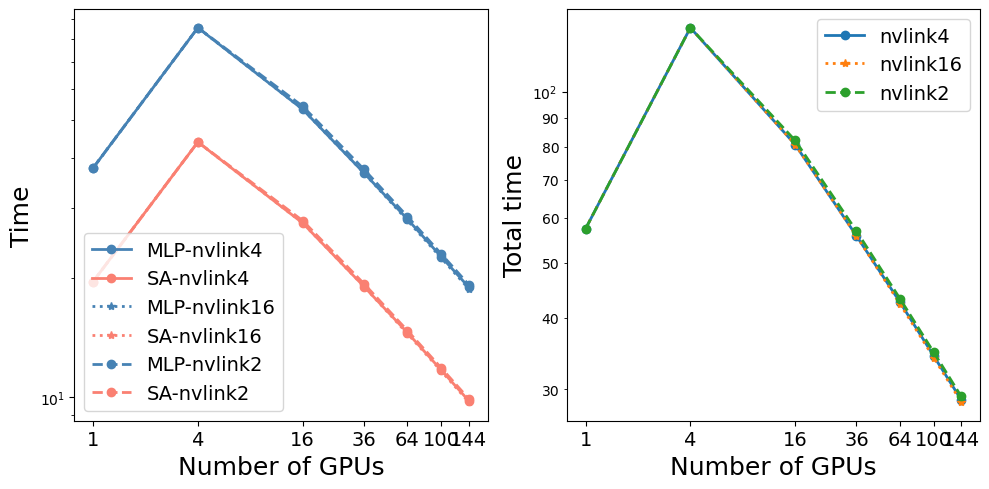

In [10]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 16, 36, 64, 100, 144]
with open('config.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

lgnd = []
lgnd_tot = []
nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
nvs = 2
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")